In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import time
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

import matplotlib.pyplot as plt

In [450]:
from app.utils import ImageWrapper
from app.custom import RemoveBusBars, Orient, BusbarMask
from app.transforms import FFT, IFFT, CreateOnesMask, PCA
from app.filters import CreateKernel, Convolve, Canny, HOG, Threshold_Multiotsu
from app.imager import ImageLoader, DefectViewer, Show, Exposure

In [569]:
# Seed used in show to show the same images when num_images option is set
seed = 1234

# Utility function for plotting during this EDA:
def plot_10(in_imgs):
    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(10):
        axs[i].imshow(in_imgs[i], cmap='Greys_r')
        axs[i].set_title(f'{i}')

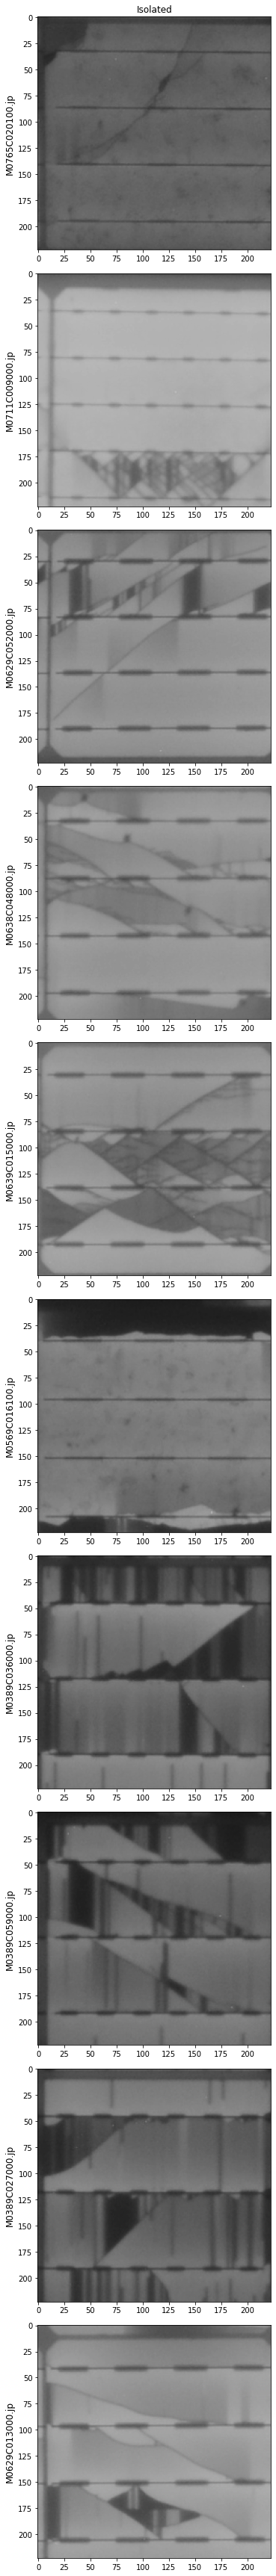

In [452]:
# Load 100 examples and name the category for it. Category is like a title for images
n_samples = 10
isolated = (DefectViewer() << (ImageLoader(defect_class='Isolated') << n_samples))
isolated.category = 'Isolated'
_ = Show(num_images=10, seed=seed) << (isolated)

## EDA 
Isolated Cracks have the following defining features:

- They are darker regions (areas of low luminesence) compared to the rest of the cell, and are often 'dead', which present as black in these images. 
- They are often irregular in shape, but they can be rectangular in shape. 
- They occur typically in the presence of other cracks. 

Potential Approach
- Inverting the image so that the dark regions are brigher regions (not neccesary but just more intuitive when 'subtracting' information we don't want). 
- Thresholding to keep only the brightest (previously darker) regions.
- Potential filtering of vertical lines, so the model doesn't confuse dark vertical fingers
- Potential filtering of horizontal lines, so the model doesn't the busbars. 
- Application of a blob detector to highlight the blobs.
- Erode the background


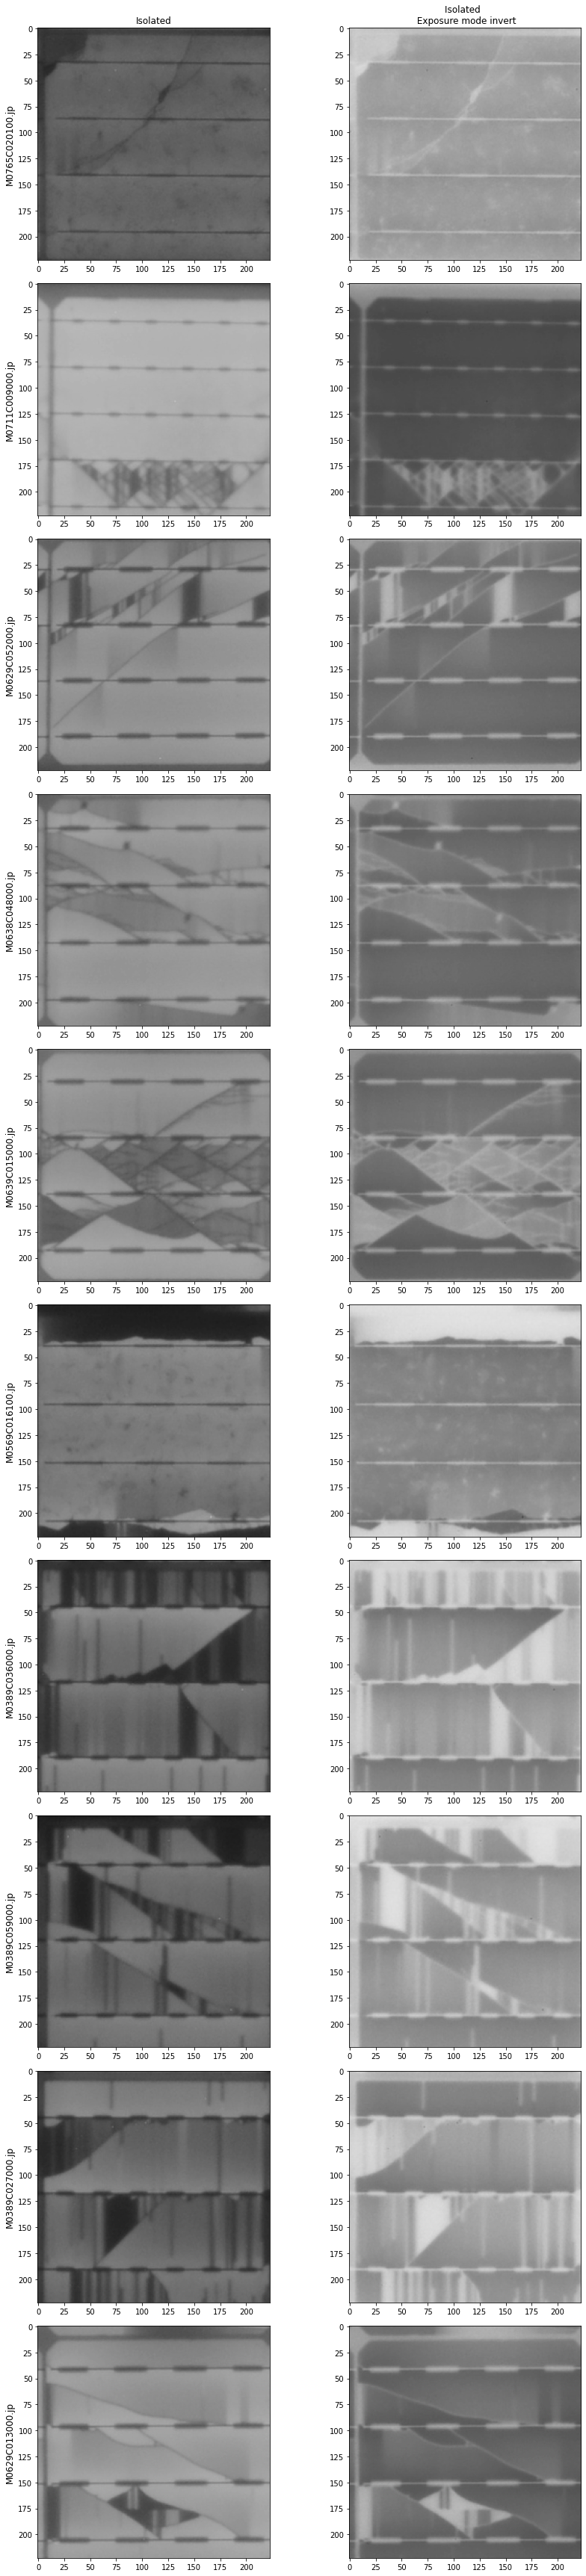

In [453]:
## INVERT IMAGES ## 
# Invert images
original, inverted = Exposure('invert') << isolated
_ = Show(num_images=10, seed=seed) << (original, inverted)

Next we apply thresholding the images using Multi-Otsu thresholding, which is a method of finding threshold boundaries which maximises the inter-bin variances. Because of this, we can apply a local threshold for each image, rather than a global value for all images. This is particularly useful because the incoming images are not normalised/scaled to a global value - a bright region on a bad cell may actually in absolute intensity correspond to a poor region on a good cell. 

In [477]:
## Apply multi-otsu thresholding, we experiment with 2 and 3 thresholds. 
_, thresholded_2 = (Threshold_Multiotsu(2) << (Exposure('invert') << isolated))
_, thresholded_3 = (Threshold_Multiotsu(3) << (Exposure('invert') << isolated))

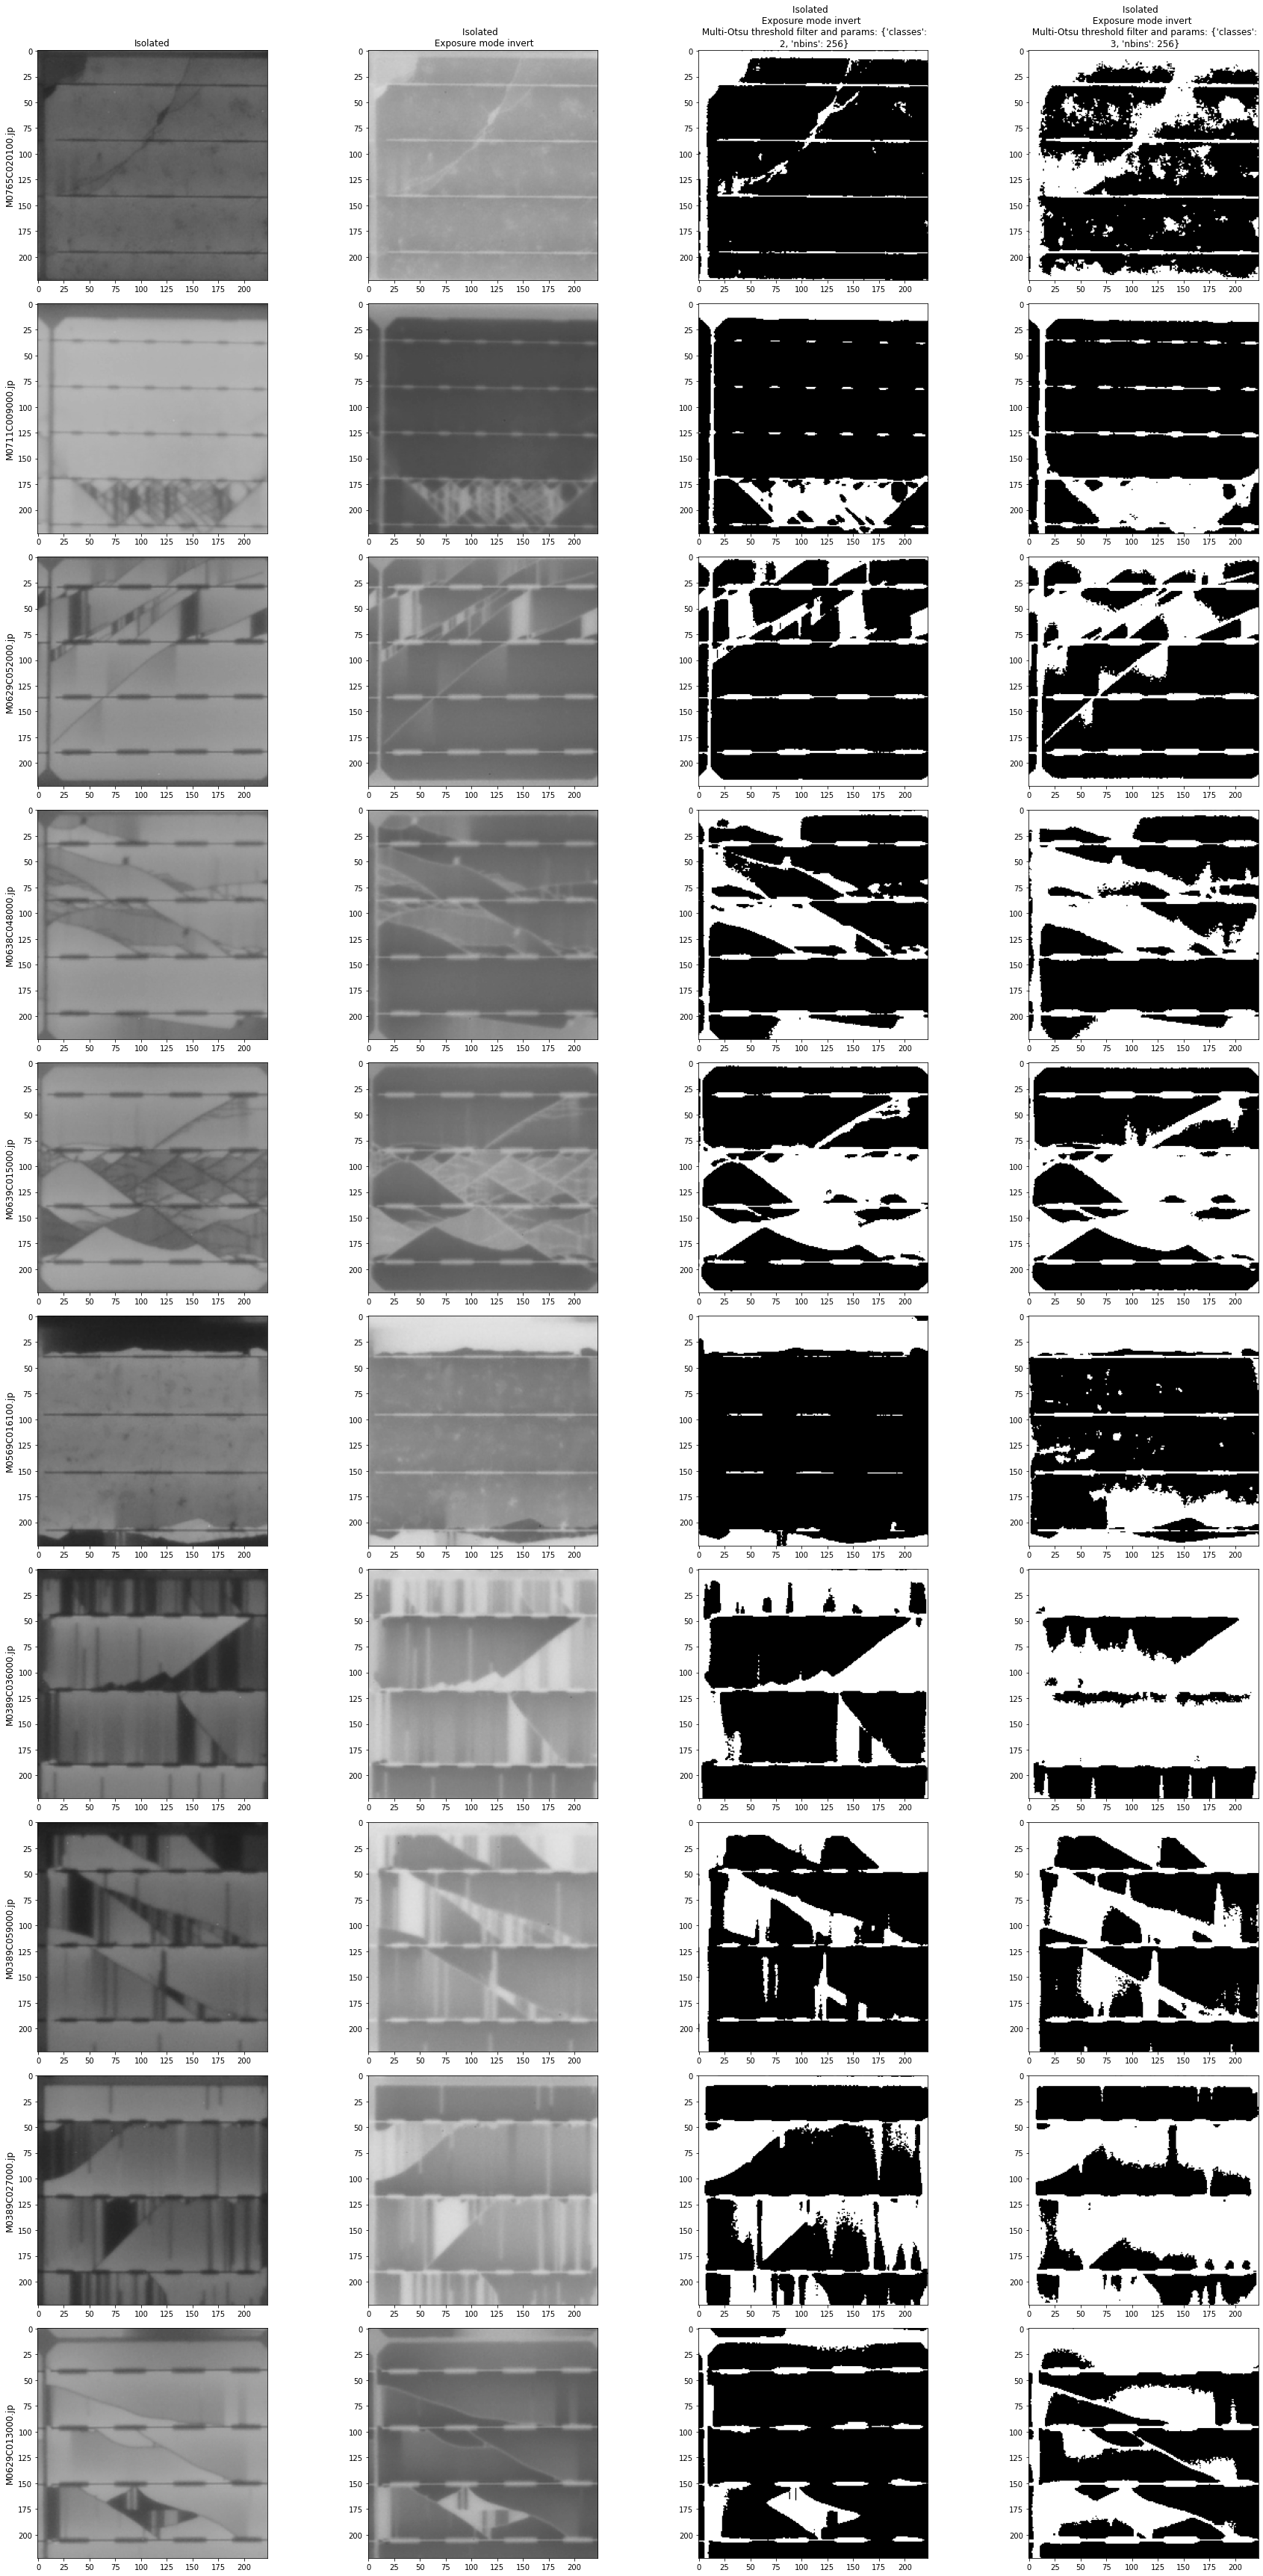

In [478]:
_ = Show(num_images=10, seed=seed) << (original, inverted, thresholded_2, thresholded_3)

# This looks pretty reasonable for only two rather simplistic transforms. Having two threshold levels appears to be the right balance between feature vs noise extraction. 

There are a few issues though:

- The busbar pattern is occasionally picked up during the thresholding. 
- Misaligned border crop regions are also picked up during the thresholding.
- Sometimes cracks and thin diagonal and vertical lines are remaining after thresholding. 

The busbar effect can perhaps be countered by:
- removing the busbars and blurring. 
- Isolating and subtracting the thresholded busbar pattern and then subtracting this from the thresholded image would remove the pattern where it occurs only. 
- subtracting all non-busbar regions. 
- applying the multi-otsu threshold only to the busbar regions to create a mask.
- subtracting this mask from the thresholded image. 

The cracks and thin diagonal lines can perhaps be addressed by a combination of:

- Blurring the image with a gaussian kernel may help with avoiding the pick up of unwanted high frequency features such as cracks and thin vertical lines. 
- Band pass filtering to remove high frequency information. 


# Busbar removal

A custom function, BusbarMask was built to detect and remove the busbars via masking. The rough algorithm for this is as follows:
- a Farid horizontal mask is used to extract any horizontal gradients and the returned signal is summed along the rows and squared. 
- A series of filters are applied on the 1D signal, including an edge mask, since we know there should not be any busbars at the very edges.
- A gaussian blur is then applied to the remaining signal.
- A peak finding algorithm is used to find the peaks, which correspond to the centre of the busbar positions.
- The remaining peaks are then 'broadened' by an input factor to widen the mask. 
- The values are then thresholded to be either 1 or zero and then the mask is lengthened across all columns, to mask out the full row. 
- The resulting mask is then either multiplied by the image or returned as a one-hot encoded matrix. 

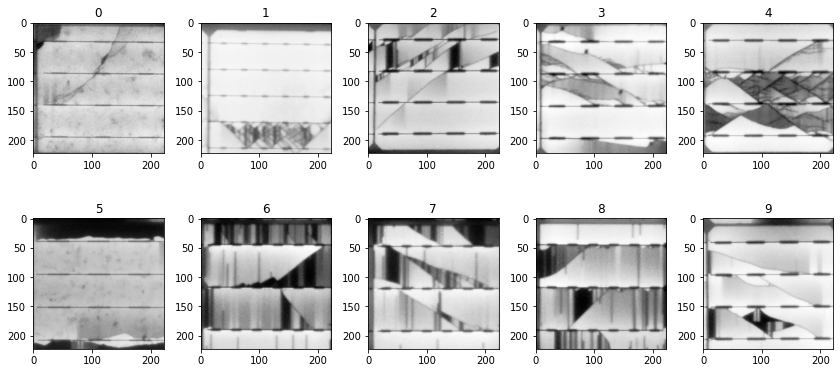

In [570]:
# Original Images
plot_10(isolated.images)

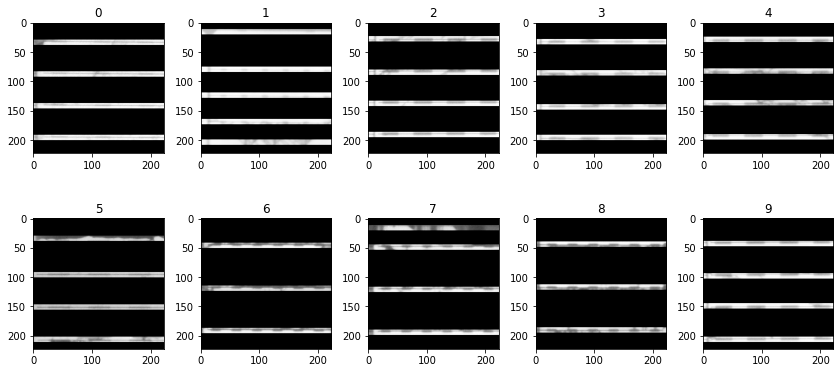

In [608]:
# masked_images
masks = BusbarMask(edge_buffer=15, min_spacing=30, broadening=4).apply(isolated.images)
plot_10(isolated.images * masks)

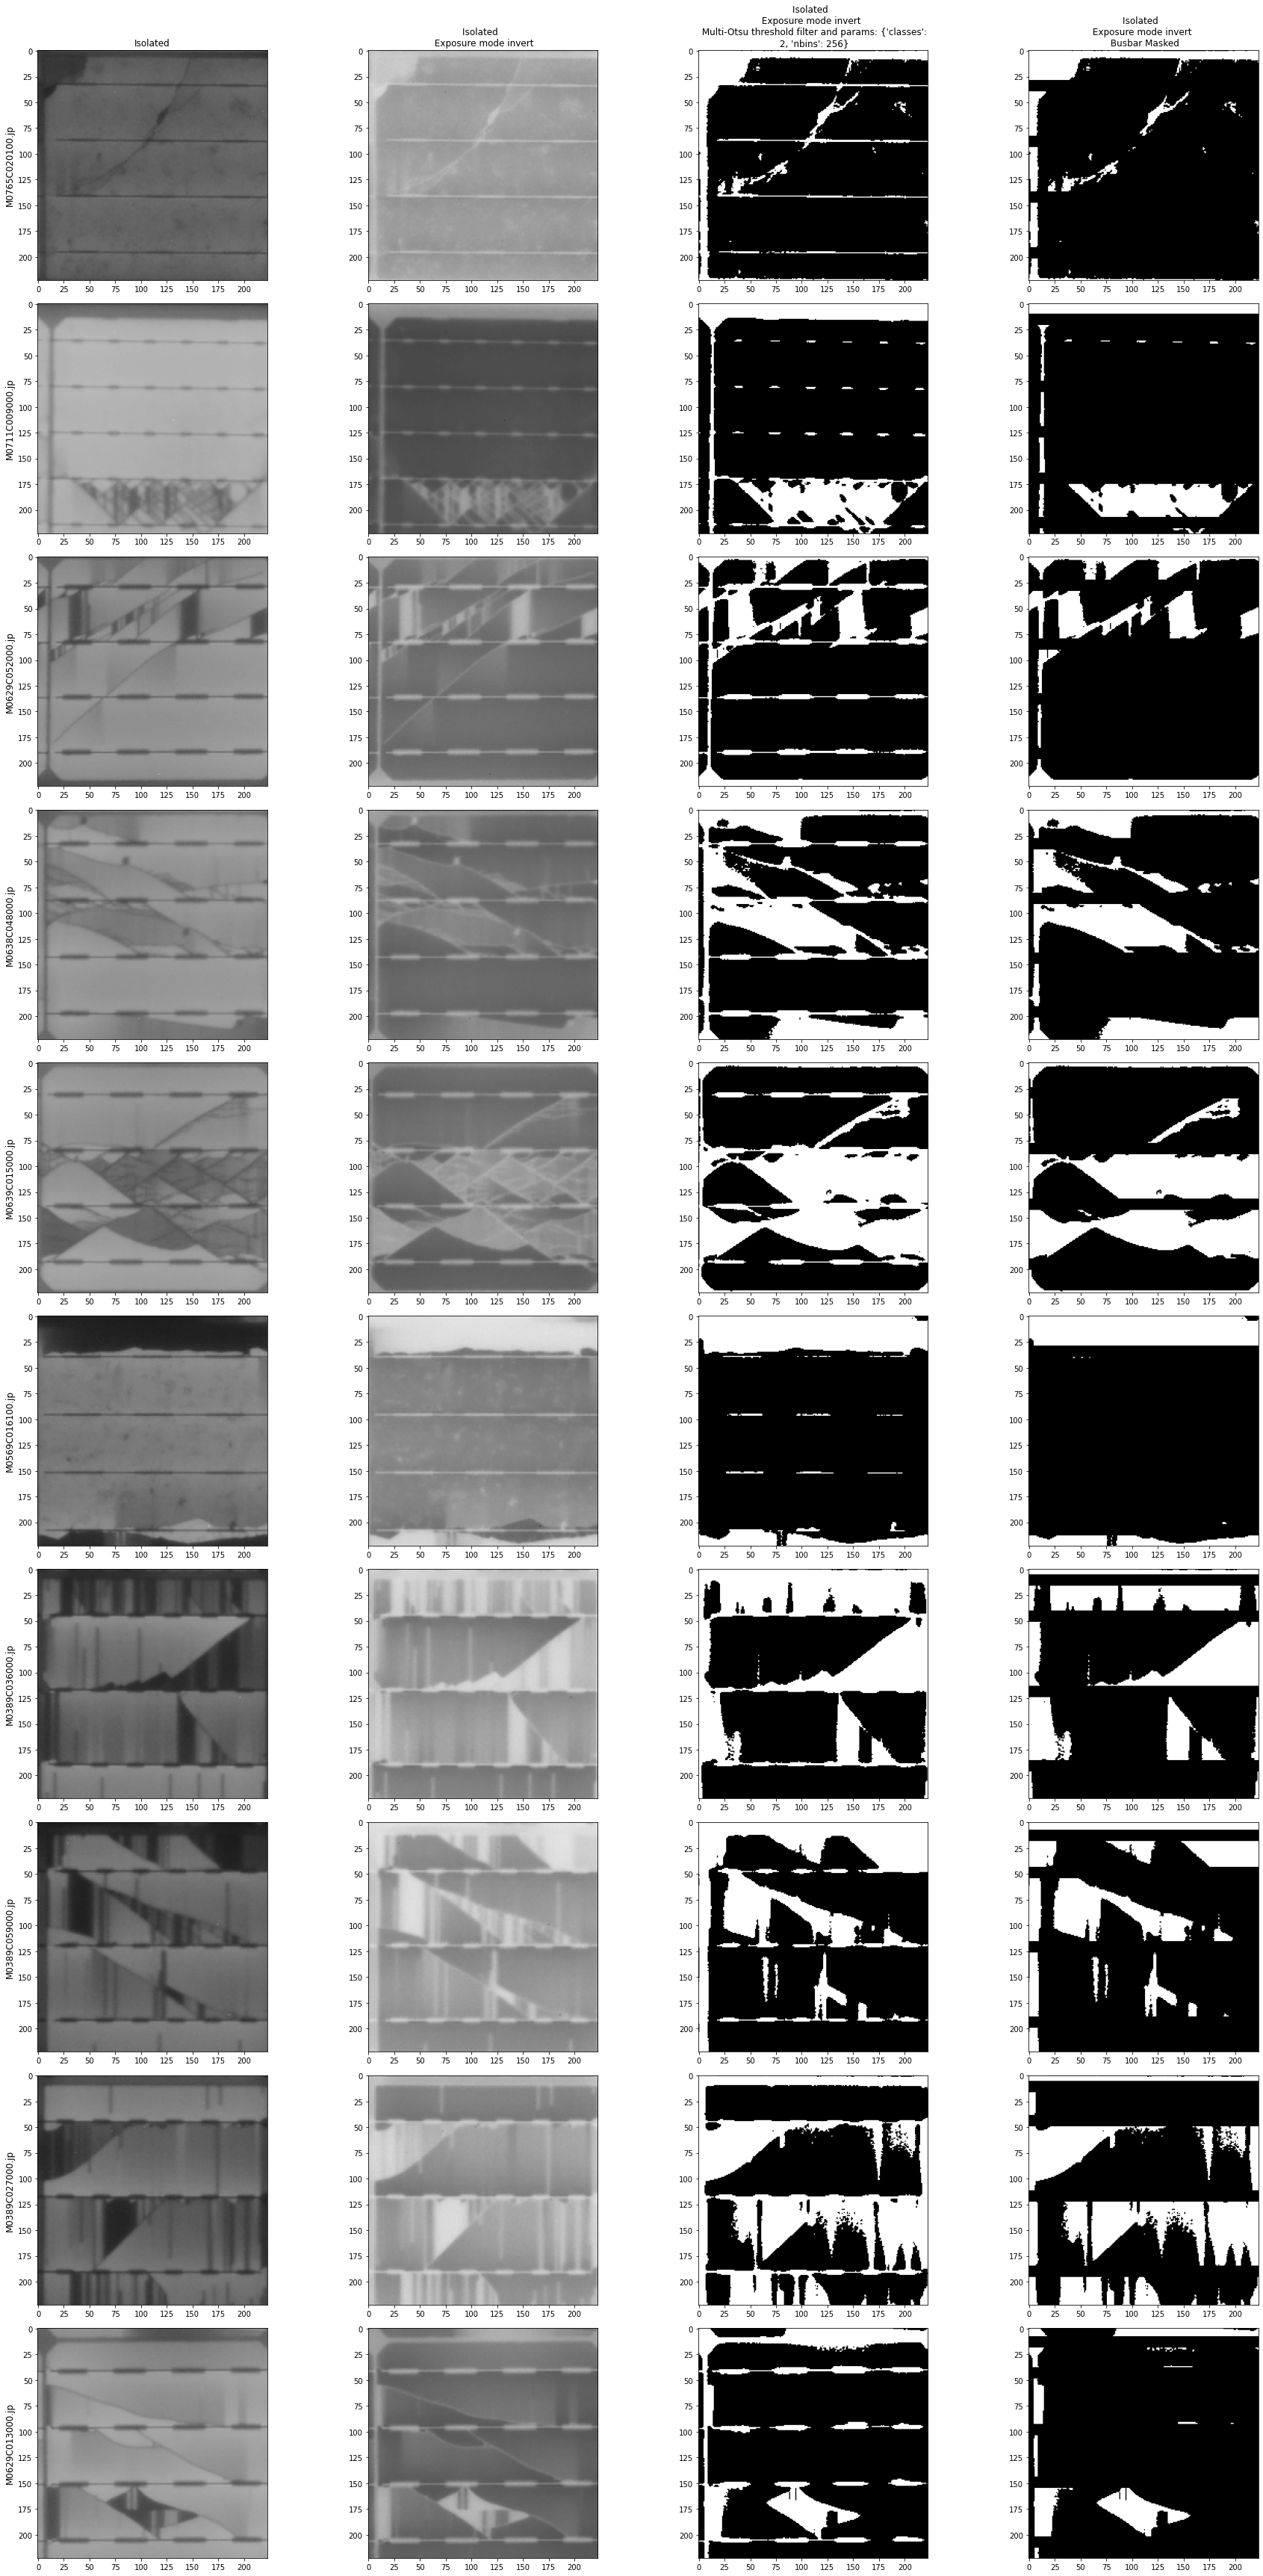

In [583]:
# Busbar removal example in pipeline
# Detect Busbars and remove masks
_ , thresholded_masked = BusbarMask(edge_buffer=10, min_spacing=25, broadening=5) \
        << (Threshold_Multiotsu(2) << (Exposure('invert') << isolated))

_ = Show(num_images=10, seed=seed) << (original, inverted, thresholded_2, thresholded_masked)

In [584]:
from scipy import ndimage

# function to create Laplacian kernels of a certain size
def LapMask(n):
    mask = np.ones((n,n))
    mask[int(np.ceil(n/2))-1, int(np.ceil(n/2))-1] = 1 - n**2
    return mask

def convolve(in_img, in_kernel):
    return ndimage.convolve(in_img, in_kernel, mode='reflect')

In [587]:
test_img = original.images[0]

array([[0.23529412, 0.23137255, 0.23529412, ..., 0.30196078, 0.28627451,
        0.27058824],
       [0.23137255, 0.23137255, 0.22352941, ..., 0.26666667, 0.24313725,
        0.23529412],
       [0.23529412, 0.23137255, 0.22745098, ..., 0.22352941, 0.20784314,
        0.19607843],
       ...,
       [0.33333333, 0.29019608, 0.2627451 , ..., 0.35294118, 0.35294118,
        0.34509804],
       [0.29019608, 0.25882353, 0.23921569, ..., 0.34901961, 0.34901961,
        0.33333333],
       [0.2627451 , 0.24313725, 0.23921569, ..., 0.3254902 , 0.32941176,
        0.32156863]])

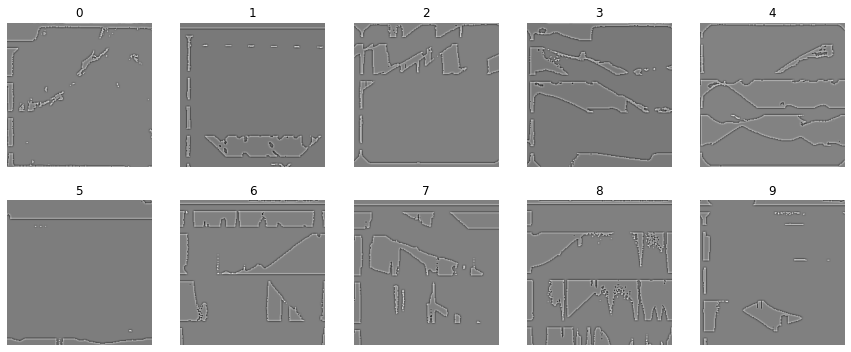

In [606]:
# create figure
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()

for i in range(len(thresholded_2.images)):
    # BEGIN SOLUTION
    # create a laplacian kernel according to the current scale
    kernel = LapMask(5)

    # apply the laplacian filter to the original image
    out_im = convolve(thresholded_masked.images[i], kernel * -1)
    # END SOLUTION

    # plot output image for each scale
    axes[i].imshow(out_im, cmap='gray')
    axes[i].set_title(f'{i}')
    axes[i].axis('off')

plt.show()

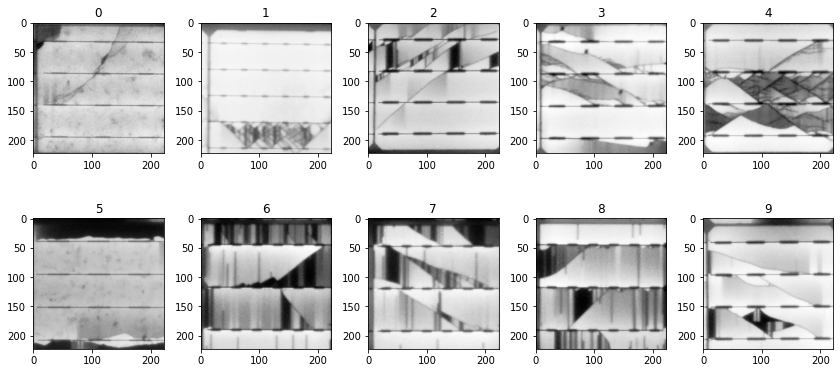

In [595]:
plot_10(original.images)